It would look neat with two cells, left pi/tajD and right roh with the roh legend at the side, however I think ibd is worth mentioning as it wasn't applied to all pops in the phase 1 paper - so

four cells > TR=pi, TL=Tajd, BR=ibd, BL=roh/legend

In [5]:
%run setup.ipynb
from itertools import combinations
from intervaltree import Interval, IntervalTree
from pathlib import Path
import logging
LOGFORMAT = '%(asctime)s : %(levelname)s : %(message)s'
logging.basicConfig(format=LOGFORMAT, level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")
populations = phase2_ar1.pop_ids
pop_colours = phase2_ar1.pop_colors
pop_labels = phase2_ar1.pop_labels

# setup pi and taj'D

In [6]:
winsize = '20000'
chrom = '3R'
start = 1000000
stop = 37000000
pi_fn = '../phase2.AR1/extras/diversity/pi.windows_eqaccess.h5'
pi = h5py.File(pi_fn, 'r')
td_fn = '../phase2.AR1/extras/diversity/Tajimas_D.windows_eqaccess.h5'
td = h5py.File(td_fn, 'r')

In [7]:
#make boolean to compress to accessible region
pia = pi[winsize][chrom]['AOcol']['windows'][:]
tda = td[winsize][chrom]['AOcol']['windows'][:]
geoff = (pia[:,0] > start) & (pia[:,1] < stop)
pia.shape, geoff.shape

((1621, 2), (1621,))

In [8]:
#make dict of acc region pi to boxplot
div_dic = {}
taj_dic = {}
for pop in populations:
    pi_all = pi[winsize][chrom][pop]['pi'][:]
    td_all = td[winsize][chrom][pop]['tajd'][:]
    div_dic[pop] = pi_all.compress(geoff, axis=0)
    taj_dic[pop] = td_all.compress(geoff, axis=0)

In [181]:
def pi_plot(ax=None):
    fig = plt.figure(1, figsize=(10, 2.5))

    # Create an axes instance
    if ax == None:
        ax = fig.add_subplot(111)
    sns.despine(ax=ax)
    # Create the boxplot
    lw=0.7
    bp = ax.boxplot(x=[div_dic[pop] for pop in populations],
            labels=populations,  patch_artist=True, 
            medianprops={"color":"k", "linewidth":lw},
            whiskerprops={"color":"k"}, 
            capprops={"color":"k"},
            showfliers=False,
            flierprops={"c":"k", "markersize":0.7})

    for p in populations:
        plt.xticks(rotation='vertical')

    plt.ylabel(r'$\pi$', rotation = 0, fontsize=12)
    plt.xlabel('population', va='top')
    plt.ylim(0,0.022)

    for patch, color in zip(bp['boxes'], [pop_colours[pop] for pop in populations]):
        patch.set_color('k')
        patch.set_facecolor(color)
        patch.set_linewidth(lw)
        
def taj_plot(ax=None):
    # Create a figure instance
    fig = plt.figure(1, figsize=(10, 2.5))
    # Create an axes instance
    if ax == None:
        ax = fig.add_subplot(111)
    sns.despine(ax=ax)
    # Create the boxplot
    lw=0.7
    bp = ax.boxplot(x=[taj_dic[pop] for pop in populations],
            labels=populations,  patch_artist=True, 
            medianprops={"color":"k", "linewidth":lw},
            whiskerprops={"color":"k"}, 
            capprops={"color":"k"},
            showfliers=False,
            flierprops={"c":"k", "markersize":0.7})

    for p in populations:
        plt.xticks(rotation='vertical')

    plt.ylabel(r"Tajima's D", fontsize=12)
    plt.xlabel('population', va='top')
    plt.ylim(top=5)
    for patch, color in zip(bp['boxes'], [pop_colours[pop] for pop in populations]):
        patch.set_color('k')
        patch.set_facecolor(color)
        patch.set_linewidth(lw)

# setup ibd

In [151]:
# marker_style = {
#     'GHcol' : 'D',
#     'GHgam' : 'o',
#     'BFgam' : 'o',
#     'BFcol' : 'D',
#     'UGgam' : 'o',
#     'GM' : '*',
#     'GW' : '*',
#     'KE' : '*',
#     'CMgam' : 'o',
#     'FRgam' : 'o', 
#     'GQgam' : 'o', 
#     'AOcol' : 'D', 
#     'GAgam' : 'o', 
#     'GNgam' : 'o', 
#     'GNcol' : 'D', 
#     'CIcol' : 'D'
# }


marker_style = {
    'GHcol' : 'o',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'o',
    'UGgam' : 'o',
    'GM' : 'o',
    'GW' : 'o',
    'KE' : 'o',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'o', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'o', 
    'CIcol' : 'o'
}

regions = {
    "3R": (1000000, 37000000),
    "3L": (15000000, 41000000)}
seqs = sorted(regions.keys())
starts = [regions[c][0] for c in seqs]
ends = [regions[c][1] for c in seqs]

In [106]:
ibd_data = Path("~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2", "output")
genome = phase2_ar1.genome_agamp3
IBDCOLS = ["sample1", "i1", "sample2", "i2", "chrom", "start", "end", "LOD"]

def load_raw_ibd(seqid, popid, min_chunk_size):
    
    fn = ibd_data / seqid / (popid + ".ibd")
    logging.info("loading {0}".format(fn))
    df = pd.read_table(fn, names=IBDCOLS)
    df["chunk_size"] = df.end - df.start
    return df.query("chunk_size >= @min_chunk_size")

In [19]:
def get_IBD(chrom, start, stop, pop, samples, min_size=100000):
        
    if not isinstance(chrom, str):
        f  = {}
        for _c, _s, _e in zip(chrom, start, stop):
            f[_c] = get_IBD(_c, _s, _e, pop, samples, min_size)

        f = pd.concat(f).groupby(level=[1, 2]).aggregate(sum)
        
    else:
        
        ibddf = load_raw_ibd(chrom, pop, min_size)
        all_combs = list(combinations(samples, 2))
        logging.info("Loaded {0} {1}: processing...".format(chrom, pop))
        
        mi = pd.MultiIndex.from_tuples(all_combs, names=["Sample1", "Sample2"])
        f = pd.DataFrame(data=0, index=mi, columns=["IBDsum", "IBDcount"])

        # cut the start and stop
        g = ibddf.groupby(["sample1", "sample2"])
        
        for spair, df in g:
            
            x = df[["start", "end"]]
            tree = IntervalTree.from_tuples(x.to_records(index=False))
                
            tree.chop(1, start)
            tree.chop(stop, len(genome[chrom]))
            f.loc[spair] = sum([iv.length() for iv in tree]), len(tree)
            del tree
        
    return f

In [20]:
ibd_dict = {
    pop: get_IBD(
        seqs, starts, ends,
        pop, 
        sorted(phase2_ar1.df_samples.query("population == @pop").index),
        min_size=0) for pop in phase2_ar1.pop_ids}

2019-05-22 11:55:35 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/AOcol.ibd
2019-05-22 11:55:35 : INFO : Loaded 3L AOcol: processing...
2019-05-22 11:55:40 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/AOcol.ibd
2019-05-22 11:55:40 : INFO : Loaded 3R AOcol: processing...
2019-05-22 11:55:46 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GHcol.ibd
2019-05-22 11:55:46 : INFO : Loaded 3L GHcol: processing...
2019-05-22 11:55:48 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GHcol.ibd
2019-05-22 11:55:48 : INFO : Loaded 3R GHcol: processing...
2019-05-22 11:55:50 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/BFcol.ibd
2019-05-22 11:55:50 : INFO : Loaded 3L BFcol: processing...
2019-05-22 11:55:55 : INFO : loading ~/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/BFcol.ibd
2019-05-22 11:55:55 : INFO : Loaded 3R BFcol: 

In [21]:
all_pop_sum = pd.concat(ibd_dict, names=["population"])
all_pop_sum.sort_values("IBDsum", ascending=False).head(10)

IBDsum  IBDcount
population Sample1  Sample2                     
AOcol      AR0042-C AR0049-C  62000000         2
CMgam      AN0142-C AN0169-C  62000000         2
           AN0020-C AN0169-C  62000000         2
           AN0085-C AN0107-C  62000000         2
           AN0147-C AN0179-C  62000000         2
           AN0171-C AN0205-C  62000000         2
           AN0020-C AN0142-C  62000000         2
           AN0124-C AN0183-C  62000000         2
           AN0154-C AN0193-C  62000000         2
           AN0010-C AN0171-C  62000000         2

In [22]:
all_pop_sum["log_IBDsum"] = np.log(all_pop_sum.IBDsum)

/home/chris/Git/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [27]:
median_values = all_pop_sum.groupby(level="population").agg(np.median)
sorted_med_ibd = median_values.IBDsum.sort_values(ascending=False)

In [148]:
def ibd_plot(ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(12, 12))
    for ix, pop in enumerate(sorted_med_ibd.index):

        ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
        ax.scatter(
            ibd.IBDsum, 
            ibd.IBDcount, 
            alpha=0.5, 
            c=(phase2_ar1.pop_colors[pop],),
            marker=marker_style[pop],
            label=phase2_ar1.pop_labels[pop])

        ax.set_xscale("log", nonposx='clip')

    ax.set_xlim((10**5, 2 * 10**8))
    ax.set_ylim(0,100)
    ax.grid(True)
    # leg = ax.legend()
    ax.set_ylabel("IBD count")
    ax.set_xlabel("IBD sum (bp)")
    sns.despine(ax=ax);

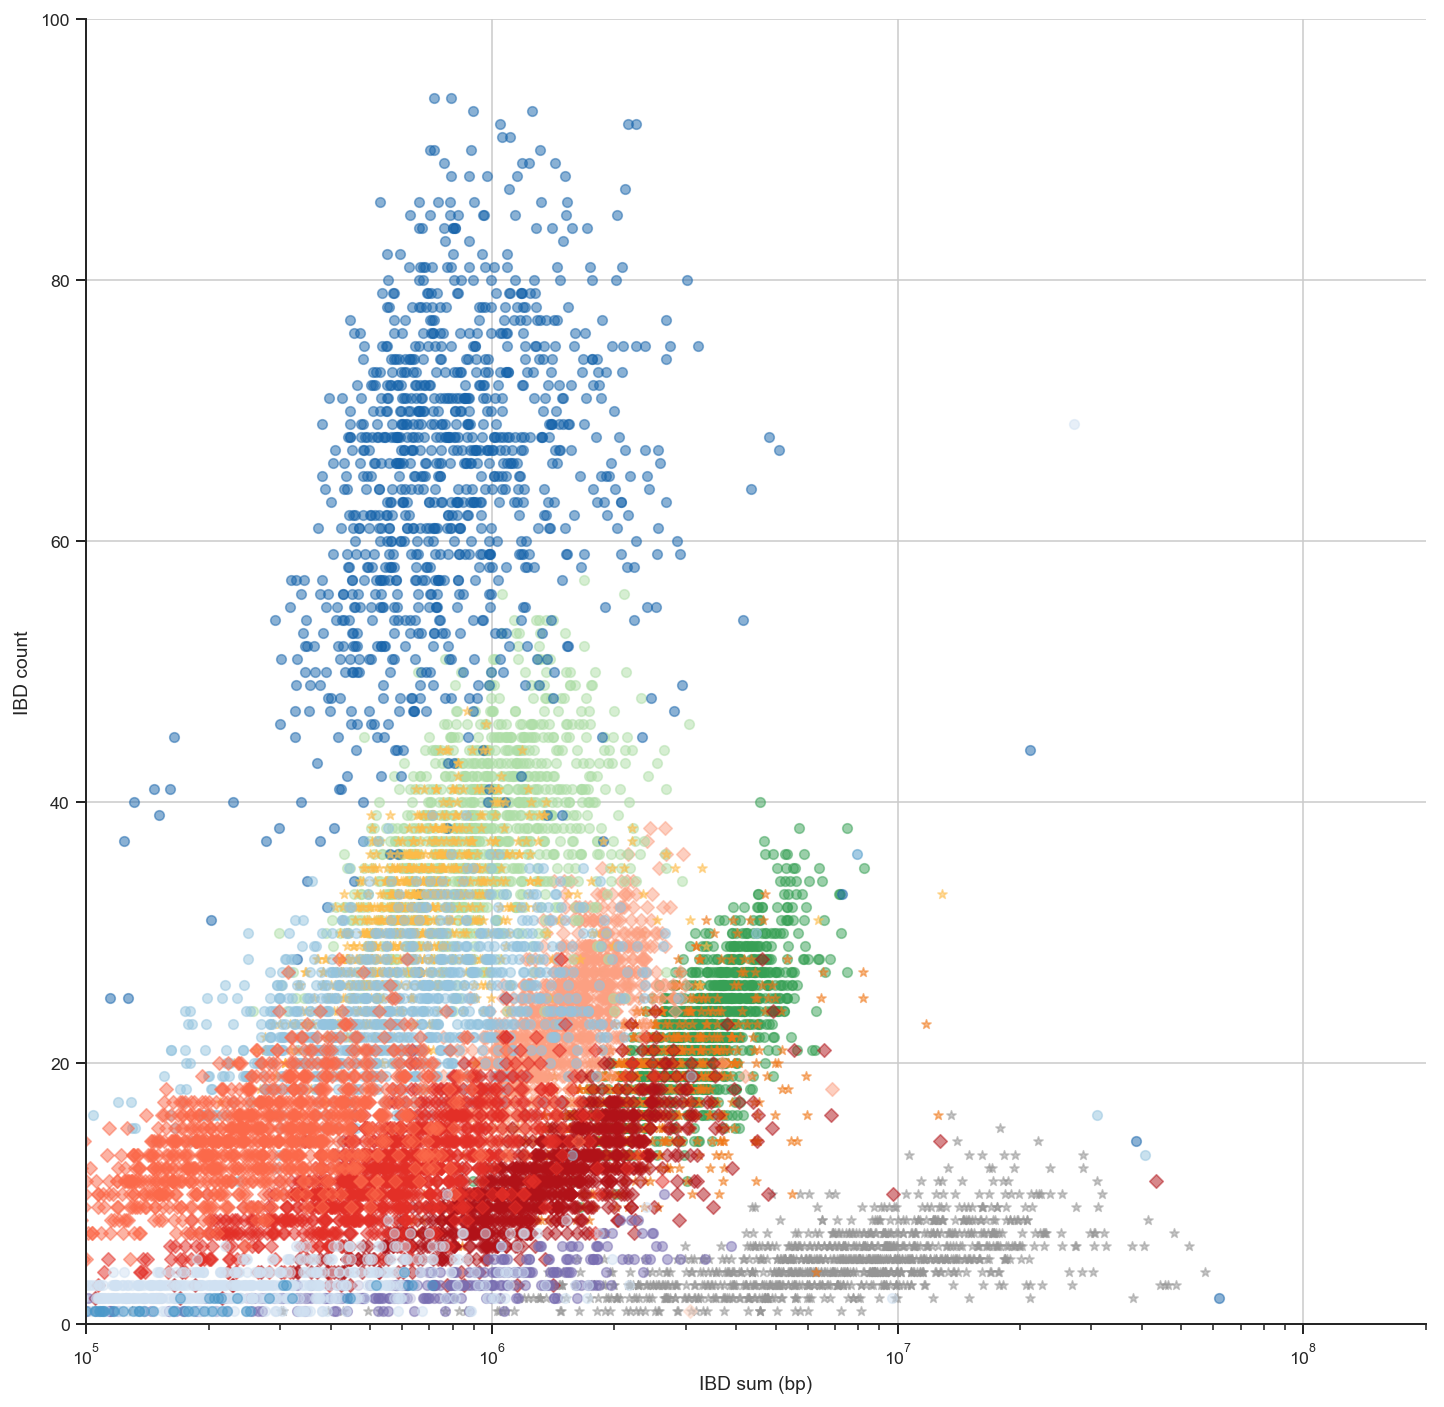

In [149]:
ibd_plot()

# roh

In [ ]:
min_size_roh = 10000

In [43]:
roh_path_main = Path("../phase2.AR1/roh/main/runs_of_homozygosity.zip")
roh_path_x = Path("../phase2.AR1/roh/crosses/runs_of_homozygosity.zip")

In [53]:
zz = zarr.ZipStore(roh_path_main)
roh_main = zarr.Group(zz)
zz = zarr.ZipStore(roh_path_x)
roh_x = zarr.Group(zz)
xx = phase2_ar1.df_samples.iloc[0].name

In [50]:
# load cross metadata: parents only
cross_metadata = pd.read_csv(
    Path(phase2_ar1.accessibility_dir) / ".." / "samples/cross.samples.meta.txt",
    index_col=1,
    sep="\t").query("role == 'parent'")
#drop uncertain cross
cross_metadata = cross_metadata.loc[~cross_metadata.colony_id.str.contains("/")]

In [51]:
def create_roh_table(samples, contigs, rohhandle, minrohsize=100000):

    mi = pd.MultiIndex.from_product([contigs, samples])
    roh_df = pd.DataFrame(index=mi, columns=["nROH", "sumROH"])
    
    for ix, row in roh_df.iterrows():

        chrom, sample = ix

        # get ROH of each sample/n
        try:
            size = rohhandle[chrom][sample]["length"][:]
            size = np.compress(size >= minrohsize, size)
            roh_df.loc[ix] = len(size), np.sum(size)    
            
        except KeyError:
            print(chrom, sample)
            roh_df.loc[ix] = 0, 0

    roh_summary = roh_df.groupby(level=1).agg(sum)
    totlen = sum([len(phase2_ar1.genome_agamp3[c]) for c in contigs])
    roh_summary["Froh"] = roh_summary.sumROH / totlen
    
    return roh_summary

In [54]:
roh_table_main = create_roh_table(phase2_ar1.df_samples.index, autosomes, roh_main)

In [55]:
roh_table_x = create_roh_table(cross_metadata.index, autosomes, roh_x)

3R AD0278-C


In [57]:
# merge with annotations for plotting
annotation = roh_table_main.join(phase2_ar1.df_samples[["population"]])
annotation_x = roh_table_x.join(cross_metadata[["colony_id"]])

In [58]:
mdict = dict(zip(annotation_x.colony_id.unique(), ["D", "s", "^", "v", "P"]))

In [179]:
def roh_plot(ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax)
    ax.grid(True)
    scatter = sns.scatterplot(
        x="Froh", 
        y="nROH", 
        s=50,
        hue="population", 
        palette=phase2_ar1.pop_colors, 
        data=annotation,legend=False)


    for group, df in annotation_x.groupby("colony_id"):
        ax.scatter(df.Froh, df.nROH, c="k", marker=mdict[group])

    #Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
#     handles = [plt.Line2D(
#         range(0),
#         range(0),
#         marker="o",
#         color="w",
#         markerfacecolor=phase2_ar1.pop_colors[pop], 
#         label=phase2_ar1.pop_labels[pop]) for pop in phase2_ar1.pop_ids]

    handles = [plt.Line2D(
        range(0),
        range(0),
        marker=mdict[col],
        color="w",
        markerfacecolor="k", 
        label="colony ({0})".format(col)) for col in mdict.keys()]


    plt.legend(handles=handles, bbox_to_anchor=(0.27, 1.0), loc=1, markerscale=2, fontsize=10)

    #_ = ax.legend(loc=5)

    _ = ax.set_xlabel(r"$F_{ROH (100kb)}$")
    _ = ax.set_ylabel(r"$Count\ ROH\ (100kb)$")
    _ = ax.set_ylim(0,200)

# plot

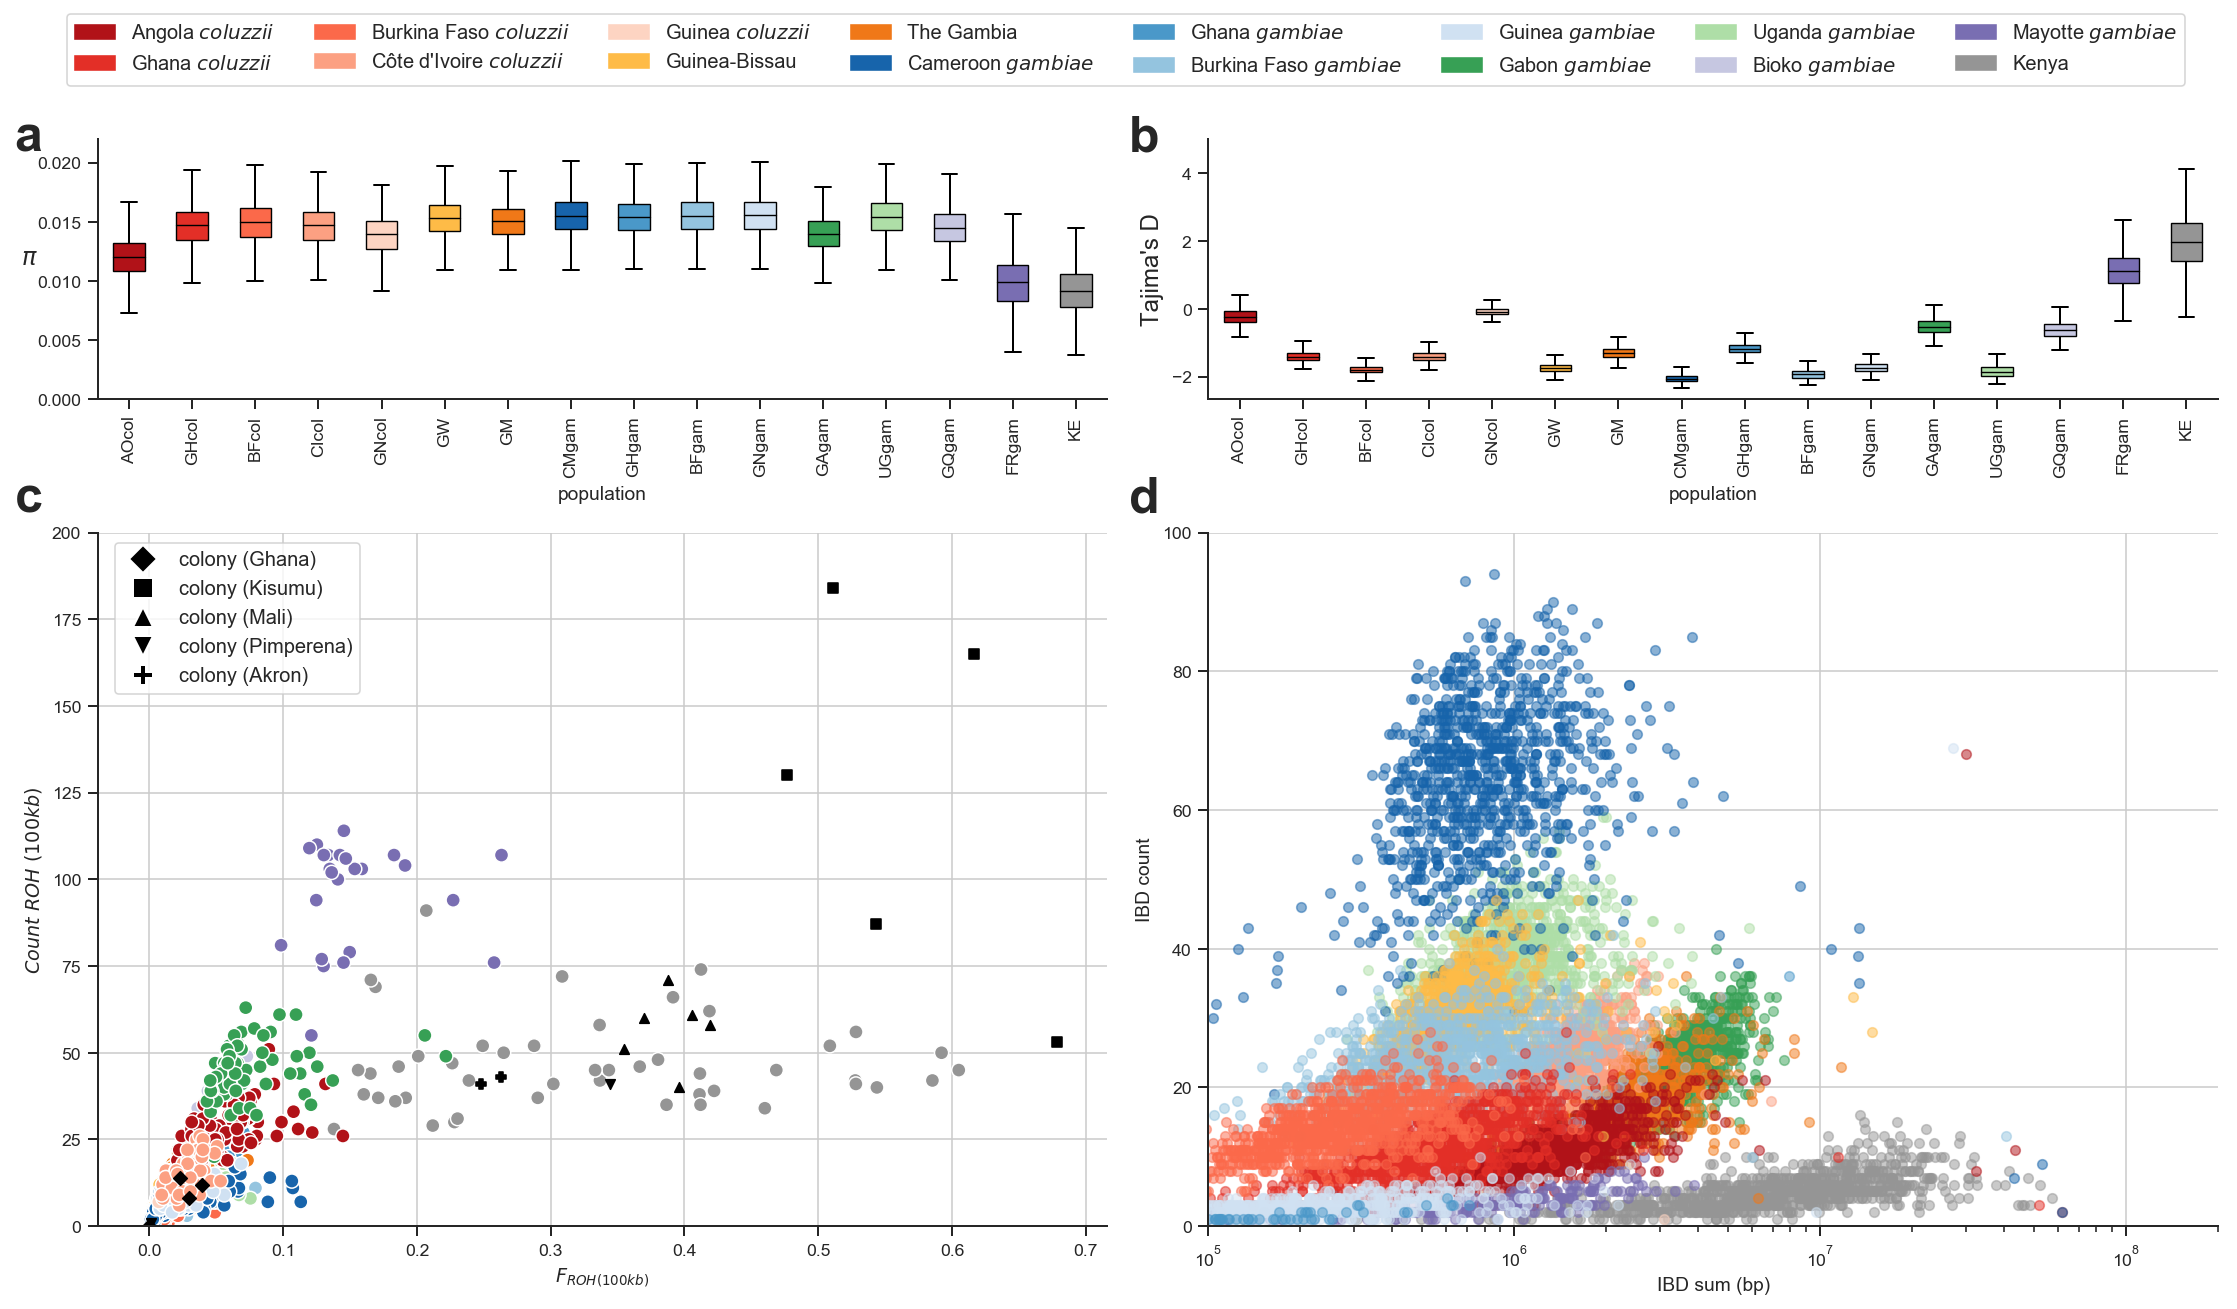

In [236]:
# create the figure
fig = plt.figure(figsize=(19, 10))

# define subplot layout
gs_nrows = 2
gs_ncols = 2
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.28, wspace=0.1, height_ratios=(0.3,0.8))
ax1 = plt.subplot(gs[0])
pi_plot(ax1)
ax2 = plt.subplot(gs[1])
taj_plot(ax2)
ax3 = plt.subplot(gs[2])
roh_plot(ax3)
ax4 = plt.subplot(gs[3])
ibd_plot(ax4)

handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(-1.14, 1.63), ncol=8, fontsize=10)
plt.text(12.5,155,'a', fontsize=25, weight='bold')
plt.text(12.5,103,'c', fontsize=25, weight='bold')
plt.text(55000.5,155,'b', fontsize=25, weight='bold')
plt.text(55000.5,103,'d', fontsize=25, weight='bold')
fig.savefig("../artwork/diversity_composite.jpeg", dpi=250, bbox_inches="tight");